In [1]:

from pathlib import Path

seed = 42
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
import category_encoders as ce

from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier


from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV, StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

from sklearn import set_config
set_config(display="diagram")

from utils.confusion_matrix import plot_confusion_matrix
from utils.medidas_biclase import calcula_medidas_biclase

import joblib, json


# GESTION DE RUTAS ABSOLUTAS

In [ ]:
# current_file = Path(__file__).resolve()
BASE_DIR = Path.cwd()
DATA_FILE = BASE_DIR.parent / "data" / "raw" / "patient_churn_dataset.csv"
MODEL_DIR = BASE_DIR.parent / "models"
METADATA_DIR = BASE_DIR.parent / "metadata"

# Crear directorios si no existen
MODEL_DIR.mkdir(parents=True, exist_ok=True)
METADATA_DIR.mkdir(parents=True, exist_ok=True)

print(f"BASE_DIR: {BASE_DIR}")
print(f"DATA_FILE: {DATA_FILE}")
print(f"MODEL_DIR: {MODEL_DIR}")
print(f"METADATA_DIR: {METADATA_DIR}")

/home/jair/Proyectos/Patient_Churn_Prediction_Dataset_for_Healthcare/notebooks
/home/jair/Proyectos/Patient_Churn_Prediction_Dataset_for_Healthcare/data/raw/patient_churn_dataset.csv


# IMPLEMENTACIÓN DE UN PIPELINE EVALUADO CON GRID SEARCH 

In [9]:
data = pd.read_csv(DATA_FILE)
data.head()

,PatientID,Age,Gender,State,Tenure_Months,Specialty,Insurance_Type,Visits_Last_Year,Missed_Appointments,Days_Since_Last_Visit,...,Overall_Satisfaction,Wait_Time_Satisfaction,Staff_Satisfaction,Provider_Rating,Avg_Out_Of_Pocket_Cost,Billing_Issues,Portal_Usage,Referrals_Made,Distance_To_Facility_Miles,Churned
0,C20000,41,Female,PA,62,Pediatrics,Medicaid,1,0,564,...,3.5,4.9,3.8,4.2,306,0,0,3,21.4,1
1,C20001,43,Female,GA,44,Internal Medicine,Self-Pay,7,4,254,...,2.6,3.1,4.7,4.3,1851,0,0,0,47.6,1
2,C20002,21,Male,MI,120,Internal Medicine,Medicaid,15,5,89,...,1.6,4.4,2.1,4.7,391,0,0,2,7.1,0
3,C20003,65,Male,FL,118,General Practice,Private,10,3,135,...,2.6,4.3,4.3,4.9,808,0,0,0,11.6,1
4,C20004,18,Female,CA,70,Cardiology,Medicaid,5,4,696,...,2.2,4.0,4.1,4.4,866,0,0,0,10.3,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   PatientID                   2000 non-null   object 
 1   Age                         2000 non-null   int64  
 2   Gender                      2000 non-null   object 
 3   State                       2000 non-null   object 
 4   Tenure_Months               2000 non-null   int64  
 5   Specialty                   2000 non-null   object 
 6   Insurance_Type              2000 non-null   object 
 7   Visits_Last_Year            2000 non-null   int64  
 8   Missed_Appointments         2000 non-null   int64  
 9   Days_Since_Last_Visit       2000 non-null   int64  
 10  Last_Interaction_Date       2000 non-null   object 
 11  Overall_Satisfaction        2000 non-null   float64
 12  Wait_Time_Satisfaction      2000 non-null   float64
 13  Staff_Satisfaction          2000 

# IDENTIFICAR VARIABLE OBJETIVO Y SEPARAR CARACTERÍSTICAS DE LA ETIQUETA

In [4]:
target_variable = 'Churned'
X = data.drop(columns = [target_variable])
y = data[target_variable]

## VALIDACIÓN

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

## IDENTIFICACION DE LAS COLUMNAS NUMÉRICAS Y CATEGÓRICAS (ORDINALES / NOMINALES)

In [6]:
real_ordinal_cols = ['Referrals_Made']
real_nominal_cols = ['Billing_Issues', 'Portal_Usage'] 

# Numericas
numerical_cols = data.select_dtypes(include = ['int64', 'float64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in real_nominal_cols and col != 'PatientID']  

# Categoricas Ordinales 
ordinal_cols = real_ordinal_cols

# Categoricas Nominales
nominal_cols = [col for col in data.columns if col not in numerical_cols and col not in ordinal_cols and col != 'PatientID' and col != 'Last_Interaction_Date']


print(f'Columnas categóricas ordinales:')
print(ordinal_cols)
print(f'\n Columnas categóricas nominales:')
print(nominal_cols)
print(f'\n Columnas numéricas:')
numerical_cols


Columnas categóricas ordinales:
['Referrals_Made']

 Columnas categóricas nominales:
['Gender', 'State', 'Specialty', 'Insurance_Type', 'Billing_Issues', 'Portal_Usage']

 Columnas numéricas:


['Age',
 'Tenure_Months',
 'Visits_Last_Year',
 'Missed_Appointments',
 'Days_Since_Last_Visit',
 'Overall_Satisfaction',
 'Wait_Time_Satisfaction',
 'Staff_Satisfaction',
 'Provider_Rating',
 'Avg_Out_Of_Pocket_Cost',
 'Referrals_Made',
 'Distance_To_Facility_Miles',
 'Churned']

## COLUMN TRANSFORMER PARA LA INGENIERÍA DE CARACTERÍSTICAS

In [7]:
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        X['frecuencia_visitas'] = X['Visits_Last_Year'] / 12
        
        visits_no_zero = X['Visits_Last_Year'].replace(0, 1)
        X['ratio_citas'] = X['Missed_Appointments'] / visits_no_zero
        
        X['costoxvisita'] = X['Avg_Out_Of_Pocket_Cost'] / visits_no_zero
        
        return X

## PIPELINE PARA CADA TIPO DE DATO

In [8]:
class SafeFrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.freq_maps_ = {}
    
    def fit(self, X, y=None):
        for col in X.columns:
            self.freq_maps_[col] = X[col].value_counts(normalize=True).to_dict()
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        for col in X.columns:
            X_copy[col] = X[col].map(self.freq_maps_.get(col, {})).fillna(0)
        return X_copy

In [9]:
## Pipeline para datos ordinales
ordinal_categories = [[0, 1, 2, 3]]
ord_pipeline = Pipeline([
    ('ord_encoder', OrdinalEncoder(categories=ordinal_categories))
])

## Pipeline para datos nominales

ohe_drop_pipeline = Pipeline([
    ('nom_ohe_dropfirst', OneHotEncoder(drop = 'first', handle_unknown='ignore'))
])

ohe_pipeline = Pipeline([
    ('nom_ohe', OneHotEncoder(handle_unknown='ignore'))
])

frecuency_pipeline = Pipeline([
    ('nom_frec', SafeFrequencyEncoder())
])

## ColumnTransformer
preprocesor = ColumnTransformer(
    transformers = [
        ('ord_encoder', ord_pipeline, ordinal_cols),
        ('nom_ohe_dropfirst', ohe_drop_pipeline, ['Gender', 'Billing_Issues', 'Portal_Usage']),
        ('nom_ohe', ohe_pipeline, ['Insurance_Type'] ),
        ('nom_frec', frecuency_pipeline, ['State', 'Specialty']) 
    ],
    remainder='drop'
)

## ESTANDARIZAZIÓN DE VARIABLES

In [10]:
escalado = StandardScaler()

## MODELOS

In [11]:
base_models = [
    ('logistic', LogisticRegression(random_state=seed, max_iter=1000)),
    ('rforest', RandomForestClassifier(random_state=seed)),
    ('xgboost', XGBClassifier(random_state=seed, use_label_encoder=False, eval_metric='logloss')),
    ('knn', KNeighborsClassifier()),
    ('svc', SVC()),
    ('gnb', GaussianNB()),
    ('dtree', DecisionTreeClassifier(random_state=seed))
]
blender = LogisticRegression()

stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=blender
)

## BALANCEO DE CLASES

In [12]:
smote = SMOTE(
    sampling_strategy='auto',
    random_state=seed
)

## ENSAMBLAR PIPELINE

In [13]:
pipeline = Pipeline([
    ('feature_engineering', FeatureEngineering()),
    ('preprocessor', preprocesor),
    ('smote', smote),
    ('model', stacking_clf)
])

In [14]:
param_grid = {
    # Parámetros para Blender
    'model__final_estimator__penalty': ['elasticnet'],
    'model__final_estimator__l1_ratio': [0.2],
    'model__final_estimator__solver': ['saga'],

    # Parámetros para cada modelo base
    'model__logistic__C': [0.01, 1],
    'model__logistic__penalty': ['elasticnet'],
    'model__logistic__solver': ['saga'],
    'model__logistic__l1_ratio': [0.2],
    
    'model__rforest__n_estimators': [100, 200],
    'model__rforest__max_depth': [10, 13],
    'model__rforest__min_samples_split': [5, 10],
    
    'model__xgboost__n_estimators': [100],
    'model__xgboost__max_depth': [3, 5],
    'model__xgboost__learning_rate': [0.01, 1],

    'model__knn__n_neighbors': [5, 7],

    'model__svc__C': [0.01, 1],
    'model__svc__kernel': ['rbf'],

    'model__gnb__var_smoothing': [1e-9],

    'model__dtree__max_depth': [10],
    
    'smote__k_neighbors': [3]
}

## GRID

In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='matthews_corrcoef',
    error_score='raise',
    cv=cv,
    n_jobs=-1,
    verbose=0
)

## ENTRENAMIENTO

In [16]:
try:
    grid.fit(X_train, y_train)
except Exception as e:
    print(f"Error durante el ajuste del modelo: {e}")

/home/jair/anaconda3/envs/CIP/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [13:56:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jair/anaconda3/envs/CIP/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [13:56:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jair/anaconda3/envs/CIP/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [13:56:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jair/anaconda3/envs/CIP/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [13:56:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jair/anaconda3/env

## MEJOR MODELO

In [17]:
best_model = grid.best_estimator_
best_params = grid.best_params_
best_score = grid.best_score_

print('Mejores parámetros encontrados:')
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"Mejor puntuación encontrada: {np.round(best_score, 4)}")

Mejores parámetros encontrados:
  model__dtree__max_depth: 10
  model__final_estimator__l1_ratio: 0.2
  model__final_estimator__penalty: elasticnet
  model__final_estimator__solver: saga
  model__gnb__var_smoothing: 1e-09
  model__knn__n_neighbors: 7
  model__logistic__C: 0.01
  model__logistic__l1_ratio: 0.2
  model__logistic__penalty: elasticnet
  model__logistic__solver: saga
  model__rforest__max_depth: 10
  model__rforest__min_samples_split: 10
  model__rforest__n_estimators: 200
  model__svc__C: 1
  model__svc__kernel: rbf
  model__xgboost__learning_rate: 1
  model__xgboost__max_depth: 5
  model__xgboost__n_estimators: 100
  smote__k_neighbors: 3
Mejor puntuación encontrada: 0.0353


## EVALUACIÓN

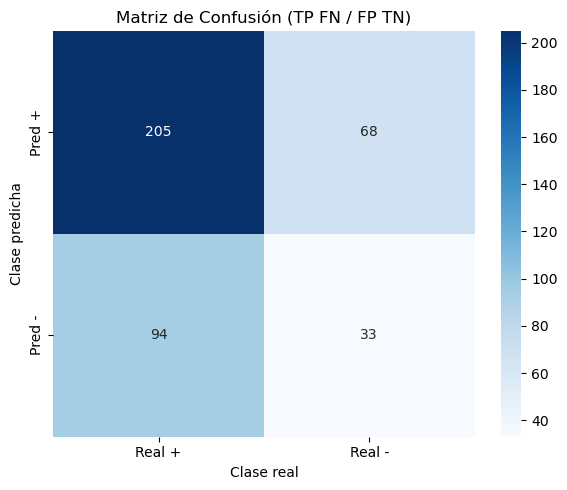

                 Medida     Valor
0              Accuracy  0.595000
1            Error Rate  0.405000
2  Recall (Sensitivity)  0.750916
3           Specificity  0.259843
4     Balanced Accuracy  0.505379
5             Precision  0.685619
6              F1 Score  0.716783
7                   MCC  0.011527


In [18]:
y_pred = best_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred)
medidas = calcula_medidas_biclase(y_test, y_pred)
print(medidas)

## GUARDAR MODELO

In [ ]:
model_path = MODEL_DIR / "01_medical_churn.pkl"
metadata_path = METADATA_DIR / "01_metadata_modelo.json"

joblib.dump(best_model, str(model_path))
print(f"Modelo guardado en: {model_path}")

metadata = {
    "best_params": grid.best_params_,
    "best_score": grid.best_score_,
    "scoring": medidas
}

with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=4)
print(f"Metadatos guardados en: {metadata_path}")